In [43]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score, completeness_score
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# === CONFIGURACIÓN ===
N_CLUSTERS = 8
LINKAGE_METHODS = ["ward", "single", "complete", "average", "centroid", "median"]

# Cargar los datos
data=pd.read_csv(r'C:\Users\tomys\OneDrive - Universidad Adolfo Ibanez\repositorio\clustering\resultados_pipeline_20250425_070339\spike_trains.csv')
filters = data["filter"]
spike_trains = data.drop(columns=["filter"]).apply(lambda row: row.dropna().to_numpy(), axis=1)
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(filters)

In [45]:
# === FUNCIONES AUXILIARES ===
def fourier(spike_train, a, b):

    multiples = np.arange(1, len(a)+1)
    multiples2 = np.arange(1, len(b)+1)
    # Compute sin(pi * spike_train[i] * multiples[j]) as a matrix
    sin_matrix = np.sin(np.pi * np.outer(spike_train, multiples)) 
    cos_matrix = np.cos(np.pi * np.outer(spike_train, multiples2))
    
    
    # Multiply each column by a[j] (broadcasting over columns)
    matrix1 = sin_matrix * a
    matrix2 = cos_matrix * b

    weighted_matrix = matrix1 + matrix2

    # Sum all elements to get the final scalar
    total_sum = np.sum(weighted_matrix)
    return   total_sum 


def fourier_dist(st1, st2, a,b):
    s1 = fourier(st1, a, b)
    s2 = fourier(st2, a, b)
    return np.abs(s1 - s2)

def heatmap_distancias(dist_matrix, title="Heatmap de Distancias", save_path=None):
    """
    Genera un heatmap a partir de la matriz de distancias entre spike trains.
    
    Parámetros:
    - dist_matrix: array o DataFrame (matriz de distancias simétrica).
    - title: título opcional del gráfico.
    - save_path: si se indica, guarda la imagen en esa ruta.
    """
    # Si es array lo convertimos en DataFrame para tener índices bonitos
    if not isinstance(dist_matrix, pd.DataFrame):
        dist_df = pd.DataFrame(dist_matrix)
    else:
        dist_df = dist_matrix

    plt.figure(figsize=(10, 8))
    sns.heatmap(dist_df,  cmap="viridis", square=True)
    plt.title(title)
    plt.xlabel("Spike Train")
    plt.ylabel("Spike Train")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"✅ Heatmap guardado en: {save_path}")
    plt.show()

In [ ]:
n = len(spike_trains)
dist_matrix = np.zeros((n, n))
a = [5,5,0]
b = [-10,-5,-5]
for i in range(n):
    for j in range(i+1, n):
        d = fourier_dist(spike_trains.iloc[i], spike_trains.iloc[j], a,b)
        dist_matrix[i, j] = d
        dist_matrix[j, i] = d

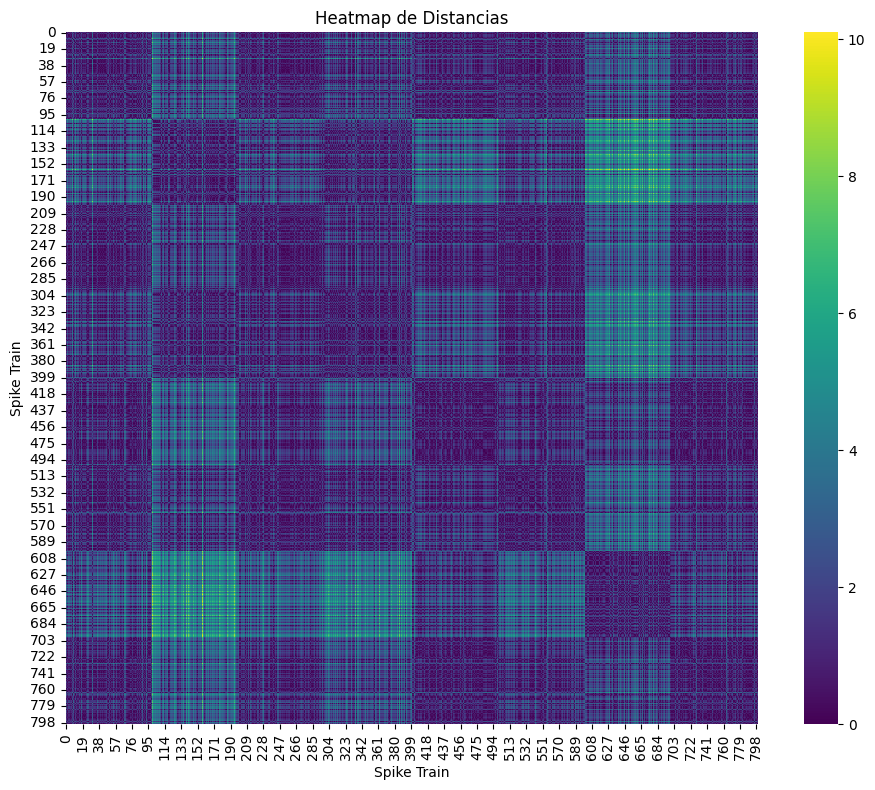

In [47]:
heatmap_distancias(dist_matrix)

In [48]:
# === HACER CLUSTERING CON DISTINTOS MÉTODOS ===
results = []

condensed = dist_matrix[np.triu_indices(n, k=1)]

for method in LINKAGE_METHODS:
    if method == "ward":
        # Ward solo acepta distancias euclidianas, pero estamos usando un condensed matrix
        linked = linkage(condensed, method="ward")
    else:
        linked = linkage(condensed, method=method)
    
    clusters = fcluster(linked, t=N_CLUSTERS, criterion="maxclust")
    
    ari = adjusted_rand_score(true_labels, clusters)
    ami = adjusted_mutual_info_score(true_labels, clusters)
    fmi = fowlkes_mallows_score(true_labels, clusters)
    completeness = completeness_score(true_labels, clusters)
    
    results.append({
        "Method": method,
        "ARI": ari,
        "AMI": ami,
        "FMI": fmi,
        "Completeness": completeness
    })

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

     Method       ARI       AMI       FMI  Completeness
0      ward  0.162141  0.274235  0.279365      0.296371
1    single  0.001921  0.041350  0.340326      0.325044
2  complete  0.129476  0.271442  0.275486      0.315198
3   average  0.125699  0.271446  0.279562      0.323934
4  centroid  0.125699  0.271446  0.279562      0.323934
5    median  0.132624  0.271076  0.276904      0.314492


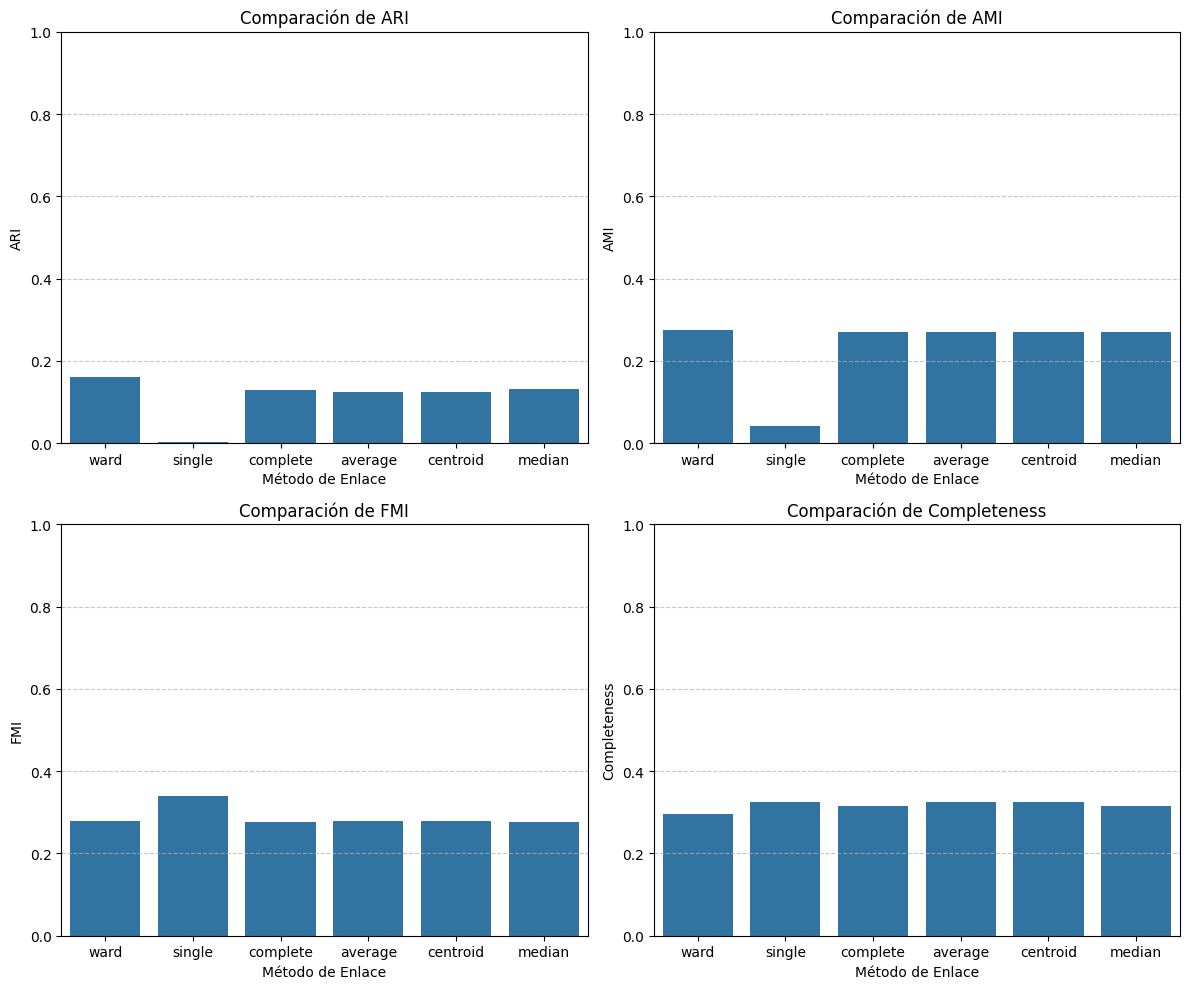

In [49]:
# === GRAFICAR COMPARATIVO ===
metrics = ["ARI", "AMI", "FMI", "Completeness"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for idx, metric in enumerate(metrics):
    ax = axs[idx // 2, idx % 2]
    sns.barplot(x="Method", y=metric, data=results_df, ax=ax)
    ax.set_ylim(0, 1)
    ax.set_title(f"Comparación de {metric}")
    ax.set_ylabel(metric)
    ax.set_xlabel("Método de Enlace")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()